In [6]:
import requests,tempfile,json
from math import sqrt,pow
from qgis import processing
from qgis.core import *
from qgis.PyQt.QtCore import QVariant
from qgis.core import QgsVectorLayer,QgsField,QgsFeature,QgsRasterLayer,QgsRasterFileWriter,QgsRasterPipe,QgsRasterProjector

from osgeo import gdal
import numpy as np

#for developing
import geopandas as gpd
import rasterio
from rasterio.plot import show
#import matplotlib.pyplot as plt
from smk_geotools import clipRaster2

<AxesSubplot:>

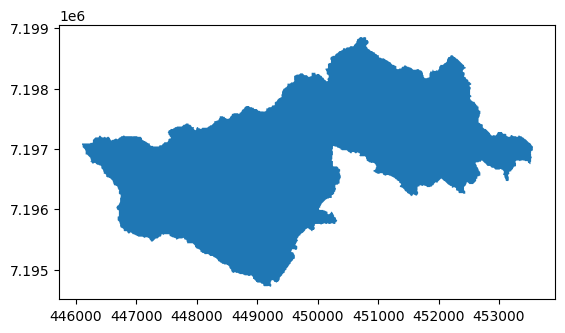

In [7]:
data_example = "data_example\ReTreeT.gpkg"
layer = "valuma_alueet"
data_qgis = QgsVectorLayer(data_example+"|layername="+layer,"cutarea","ogr")
data_df = gpd.read_file(data_example,layer = layer)

data_df

data_df.plot()

In [3]:
esri_image = 'https://aineistot.metsakeskus.fi/metsakeskus/rest/services/Vesiensuojelu/DEM/ImageServer'
esri_image = 'https://aineistot.metsakeskus.fi/metsakeskus/rest/services/Vesiensuojelu/D8_suomi/ImageServer'
wms_image = 'https://rajapinnat.metsaan.fi/geoserver/Avoinmetsatieto/CHM_newest/ows?'
wcs_name = 'paituli:luke_dtw_04'
wcs_image = 'https://paituli.csc.fi/geoserver/paituli/wcs?'


testi = "dpiMode=7&identifier=1&url=https://aineistot.metsakeskus.fi/metsakeskus/services/Vesiensuojelu/D8_suomi/ImageServer/WCSServer"
#testi = "https://aineistot.metsakeskus.fi/metsakeskus/services/Vesiensuojelu/D8_suomi/ImageServer/WCSServer"

In [8]:
def getBboxWmsFormat(in_feat:QgsVectorLayer):
    desc=in_feat.extent()
    x_min=int(desc.xMinimum())
    y_min=int(desc.yMinimum())
    x_max=int(desc.xMaximum())+1
    y_max=int(desc.yMaximum())+1
    srid=str(in_feat.crs().authid())
    exte = str(x_min)+","+str(y_min)+","+str(x_max)+","+str(y_max)
    witdth = x_max - x_min
    height = y_max - y_min
    
    return exte,srid,witdth,height

In [5]:
bb = getBboxWmsFormat(data_qgis)
print (bb)

('446099,7194719,453562,7198852', 'EPSG:3067', 7463, 4133)


In [9]:
rlayer = QgsRasterLayer(testi,"testi","wcs")
#print (data_qgis.extent())
rlayer.setCrs(data_qgis.crs())
#rlayer.setExtent(data_qgis.extent())
output = "processing\\data_example\\testi.tif"
#raster.setCrs(data_qgis.crs())
#print (raster.rasterUnitsPerPixelY())
#print (raster.crs())
#raster = QgsRasterLayer(testi,"testi","wcs")
#print ("bbox="+bb[0]+"&crs="+bb[1]+"&"+testi)
#raster.updateExtent()

if rlayer.isValid:
    #writer = QgsRasterFileWriter(raster, output)
    print ("kyllä")
    print (rlayer.extent())
    print (rlayer.height())

else:
    print ("ei hyvä")


kyllä
<QgsRectangle: 0 0, 0 0>
0


In [ ]:
#renderer = rlayer.renderer()
#provider = rlayer.dataProvider()
crs = rlayer.crs()
#pipe = QgsRasterPipe()
#projector = QgsRasterProjector()
#projector.setCrs(crs, crs)

#if not pipe.set(provider):
 #   print("Cannot set pipe provider")

# Commented for extract raw data
# if not pipe.set(renderer.clone()):
    # print("Cannot set pipe renderer")

#if not pipe.insert(2, projector):
 #   print("Cannot set pipe projector")

#out_file = 'D:/temp/temporal.tif'
output = 'P:/Aineistot/Luontotieto/QGIS/smk_tools/smk_tools/processing/data_example/test.tif'

file_writer = QgsRasterFileWriter(output)
file_writer.Mode(0)

print ("Saving")

extent = data_qgis.extent()

opts = ["COMPRESS=LZW"]
file_writer.setCreateOptions(opts)
error = file_writer.writeRaster(
    rlayer.pipe(),
    extent.width (),
    extent.height(),
    extent,
    crs)

if error == QgsRasterFileWriter.NoError:
    print ("Raster was saved successfully!")
    layer = QgsRasterLayer(output, "result")
    #QgsProject.instance().addMapLayer(layer)
else:
    print ("Raster was not saved!")

: 

In [6]:
def doEsriParams(input_polygon:QgsVectorLayer):
    bbox = getBboxWmsFormat(input_polygon)
    ss = bbox[0].split(',')
    params = {"bbox":str(round(int(ss[0])-100,-1))+","+str(round(int(ss[1])-100,-1))+","+str(round(int(ss[2])+100,-1))+","+str(round(int(ss[3])+100,-1)),
                "bboxSR":bbox[1],
                "size":str((round(int(ss[2])+100,-1)-round(int(ss[0])-100,-1))/2)+","+str((round(int(ss[3])+100,-1) - round(int(ss[1])-100,-1))/2),
                "imageSR":3067,
                "format":'tiff',
                "pixelType":"F32",
                "noData":-9999,
                "noDataInterpretation":"esriNoDataMatchAny",
                "interpolation":"+RSP_BilinearInterpolation",
                "f":"image"}
    return params
    

In [7]:
def doWmsParams(input_polygon:QgsVectorLayer):
    bbox = getBboxWmsFormat(input_polygon)
    params = {'service':'wms',
          'request':'getMap',
         'bbox':bbox[0],
          'format':'image/geotiff',
          'width':bbox[2],
          'height':bbox[3],
          'layers':'CHM_newest',
          'srs':bbox[1]}
    return params

In [8]:
def doWcsParams(input_polygon:QgsVectorLayer,url,name):
    bbox = getBboxWmsFormat(input_polygon)
    ss = bbox[0].split(',')
    covId = 'paituli:luke_dtw_04'
    version = '2.0.0'
    sset1 = 'E('+ss[0]+','+ss[2]+')'
    sset2 = 'N('+ss[1]+','+ss[3]+')'
    params = {'service':'WCS',
        'request':'GetCoverage',
        'version':version,
        'coverageId':covId}
    url = url+'subset='+sset1+'&subset='+sset2
    
    return url,params

In [9]:
def getWebRasterLayer(input_polygon:QgsVectorLayer,url:str,name:str):
    tempd = tempfile.TemporaryFile()
    tempd = tempd.name+'.tif'
    
    if url.endswith("ImageServer"):
        url = url + "/exportImage?"
        params = doEsriParams(input_polygon)
    elif url.endswith("ows?") or url.endswith("wms?"):
        params = doWmsParams(input_polygon)
    else:
        prep = doWcsParams(input_polygon,url,name)
        params = prep[1]
        url = prep[0]
        

    try:
        respo= requests.get(url,params,allow_redirects=True)
        
        if respo.status_code != 200:
           info = "Cannot connect to data: "+str(url)
           infolevel = 3
        else:
            open(tempd,'wb').write(respo.content)
    
    except:
        info = "Cannot connect to data: "+str(url)
        infolevel = 3
    
        
    try:
        test = gdal.Open(tempd)
        test_b = test.GetRasterBand(1)
        test_a = test_b.ReadAsArray()
        if np.max(test_a) > 1.0:
            info =  "data is ok!"
            infolevel = 1
            del test,test_b,test_a
        else:
           info = "Not able find data from area"
           infolevel = 3
    except:
        info = "Not able find data from area"
        infolevel = 3

    return tempd,info,infolevel

In [10]:
test_esri_image = getWebRasterLayer(data_qgis,esri_image,"")
print (test_esri_image)

('C:\\Users\\mjkesala\\AppData\\Local\\Temp\\tmpgp514q6_.tif', 'data is ok!', 1)


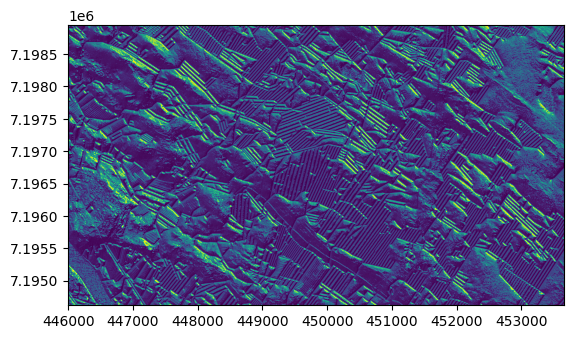

<AxesSubplot:>

In [11]:
test_raster = rasterio.open(test_esri_image[0])
show(test_raster)

In [12]:
test_wms_image = getWebRasterLayer(data_qgis,wms_image,"")
print (test_wms_image)
test_raster = rasterio.open(test_wms_image[0])
show(test_raster)

('C:\\Users\\mjkesala\\AppData\\Local\\Temp\\tmpt65tw9p8.tif', 'Not able find data from area', 3)


RasterioIOError: C:/Users/mjkesala/AppData/Local/Temp/tmpt65tw9p8.tif: No such file or directory

('C:\\Users\\mjkesala\\AppData\\Local\\Temp\\tmpvmtq0vb9.tif', 'data is ok!', 1)


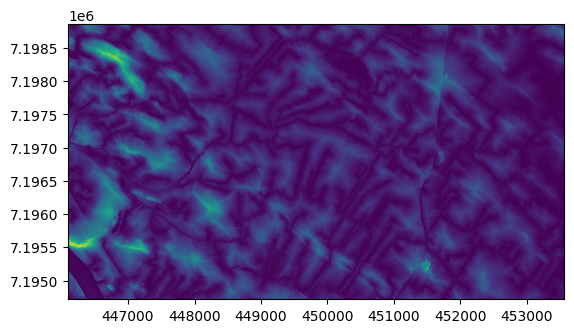

<AxesSubplot:>

In [13]:
test_wcs_image = getWebRasterLayer(data_qgis,wcs_image,wcs_name)
print (test_wcs_image)
test_raster = rasterio.open(test_wcs_image[0])
show(test_raster)

In [30]:
wfs_layer = 'https://avoin.metsakeskus.fi/rajapinnat/v1/stand/ows?'
wfs_name = 'v1:stand'
#wfs_attributes = 'GEOMETRY,GRIDCELLNUMBER,FERTILITYCLASS,LASERHEIGHT,STEMCOUNTPINE,MEANDIAMETERPINE,MEANHEIGHTPINE,STEMCOUNTSPRUCE,MEANDIAMETERSPRUCE,MEANHEIGHTSPRUCE,STEMCOUNTDECIDUOUS,MEANDIAMETERDECIDUOUS,MEANHEIGHTDECIDUOUS'
wfs_attributes = 'GEOMETRY,FERTILITYCLASS'
esri_feature = 'https://paikkatieto.ymparisto.fi/arcgis/rest/services/INSPIRE/SYKE_EliomaantieteellisetAlueet/MapServer/0'
esri_name = 'eliogeoalue'
esri_attributes = 'PaajakoNro,Nimi'

In [14]:
def doWfsParams(input_polygon:QgsVectorLayer,name:str,attributes:str):
    """This makes parameters for wfs-request of specific area
        inputs: 1. input_polygon as QgsVectorlayer , vector polygon QGS-format
                2. name as string,  layer name of service
                3, attributes as string, wanted attributes as comma separation eg. 'att1,att2,att3'"""
    bbox=getBboxWmsFormat(input_polygon)
    params = {'service':'wfs',
          'request':'getFeature',
          'typename':name,
          'propertyName':attributes,
          'bbox':bbox[0],
          'outputFormat':'json',
          'srsname':bbox[1]}
    
    return params

In [15]:
def doESRIfeatParams(input_polygon:QgsVectorLayer,name:str,attributes:str):
    """This makes parameters for esrifeature-request of specific area
        inputs: 1. input_polygon as QgsVectorlayer , vector polygon QGS-format
                2. name as string,  layer name of service
                3, attributes as string, wanted attributes as comma separation eg. 'att1,att2,att3'"""
    desc=input_polygon.extent()
    x_min=int(desc.xMinimum())
    y_min=int(desc.yMinimum())
    x_max=int(desc.xMaximum())+1
    y_max=int(desc.yMaximum())+1
    srid=str(input_polygon.crs().authid())
    srid=srid[5:]
    #print (srid)

    gparam = "geometryType=esriGeometryEnvelope&geometry="+str(x_min)+","+str(y_min)+","+str(x_max)+","+str(y_max)

    params = {"geometry":gparam,
                "geometryType":"esriGeometryEnvelope",
                "inSR":srid,
                "spatialRel":"esriSpatialRelIntersects",
                "outFields":attributes,
                "geometryPrecision":3,
                "outSR":srid,
                "f":"geojson"}
    return params


In [16]:
def getWebVectorLayer(input_polygon:QgsVectorLayer,url:str,name:str,attributes:str):
    tempd = tempfile.TemporaryFile()
    tempd = tempd.name+'.geojson'
    if url.endswith("wfs?") or url.endswith("ows?"):
        params = doWfsParams(input_polygon,name,attributes)
    else:
        url = url + '/query?'
        params = doESRIfeatParams(input_polygon,name,attributes)
    
    respo_layer =""
    try:
        respo = requests.get(url,params,allow_redirects=True)
        print (respo.status_code)
        if respo.status_code != 200:
            info = "Not getting connection to forest data: "+str(url)
            print (respo.raise_for_status())
            infolevel = 3
        else:
            respo_js = respo.json()
            with open(tempd, "w") as outfile:
                json.dump(respo_js,outfile)
            
            respo_layer = QgsVectorLayer(tempd,name,"ogr")
            if respo_layer.featureCount() == 0:
                info = "Not able to find data from area"
                infolevel = 3
            else:
                info = "Forest data is ok"
                infolevel = 1
    
    except Exception as e:
        print (e)
        info = "Not getting connection to forest data: "+str(url)
        infolevel = 3
    
    
    
    
    return respo_layer,info,infolevel

In [31]:
test_wfs = getWebVectorLayer(data_qgis,wfs_layer,wfs_name,wfs_attributes)
print (test_wfs)

data_df_wfs = gpd.read_file(test_wfs[0].source())

data_df_wfs

#data_df_wfs.plot()

200
(<QgsVectorLayer: 'v1:stand' (ogr)>, 'Forest data is ok', 1)


,id,FERTILITYCLASS,geometry
0,stand.34401161,5,"POLYGON ((448190.719 7197210.477, 448191.000 7..."
1,stand.34400077,3,"POLYGON ((450560.538 7198272.786, 450556.756 7..."
2,stand.32012769,5,"POLYGON ((452641.044 7197304.968, 452701.559 7..."
3,stand.32013155,6,"POLYGON ((453356.789 7196949.630, 453260.052 7..."
4,stand.34401573,2,"POLYGON ((450879.655 7194970.928, 450853.076 7..."
...,...,...,...
2474,stand.34401630,4,"POLYGON ((451502.423 7194901.382, 451458.437 7..."
2475,stand.34401632,3,"POLYGON ((451451.880 7194798.726, 451462.205 7..."
2476,stand.34401629,4,"POLYGON ((451476.646 7194849.593, 451474.258 7..."
2477,stand.34401631,4,"POLYGON ((451508.565 7194727.982, 451504.544 7..."


200
(<QgsVectorLayer: 'eliogeoalue' (ogr)>, 'Forest data is ok', 1)


<AxesSubplot:>

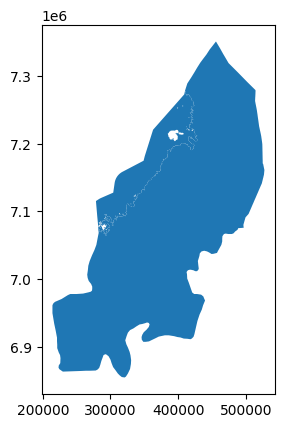

In [22]:
test_wfs = getWebVectorLayer(data_qgis,esri_feature,esri_name,esri_attributes)
print (test_wfs)

data_df_wfs = gpd.read_file(test_wfs[0].source())

data_df_wfs
data_df_wfs.plot()